##🧪 Step 1: Import Libraries and Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
np.random.seed(42)

##📥 Step 2: Load Stock Price Data (e.g., AAPL)

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.style.use("seaborn-v0_8-darkgrid")  # Use the correct style name for matplotlib >= 3.6
sns.set_palette("muted")

# Load data
data_path = "../data"
tickers = ['AAPL', 'MSFT', 'JNJ', 'PFE']

data = {}
for ticker in tickers:
    file_path = os.path.join(data_path, f"{ticker}.csv")
    if not os.path.isfile(file_path):
        print(f"Warning: File not found for {ticker}: {file_path}")
        continue
    # Check if 'Date' column exists in the CSV file
    with open(file_path, 'r') as f:
        header = f.readline().strip().split(',')
    if 'Date' in header:
        df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    else:
        df = pd.read_csv(file_path)
        if 'Date' in df.columns:
            df.set_index('Date', inplace=True)
        else:
            print(f"Warning: 'Date' column not found in {file_path}. Using default integer index.")
    if 'Close' in df.columns:
        df = df[['Close']].rename(columns={'Close': ticker})
        data[ticker] = df
    else:
        print(f"Warning: 'Close' column not found in {file_path}. Skipping {ticker}.")

# Merge all tickers into one DataFrame
df_all = pd.concat(data.values(), axis=1)
df_all.dropna(inplace=True)
df_all.head()


,AAPL,MSFT,JNJ,PFE


##🔢 Step 3: Compute Daily Log Returns

In [11]:
# Ensure the price column (named after the ticker) is numeric
df[ticker] = pd.to_numeric(df[ticker], errors="coerce")

df["Log_Returns"] = np.log(df[ticker] / df[ticker].shift(1))
df.dropna(inplace=True)

mu = df["Log_Returns"].mean()
sigma = df["Log_Returns"].std()

print(f"Mean daily return (μ): {mu:.5f}")
print(f"Standard deviation (σ): {sigma:.5f}")

Mean daily return (μ): 0.00011
Standard deviation (σ): 0.01461


##🎲 Step 4: Simulate Future Price Paths

In [13]:
forecast_days = 30
simulations = 1000
last_price = df[ticker].iloc[-1]

# Empty array to hold simulations
price_paths = np.zeros((forecast_days, simulations))

for sim in range(simulations):
    prices = [last_price]
    for t in range(1, forecast_days):
        drift = mu - 0.5 * sigma**2
        shock = sigma * np.random.normal()
        price = prices[-1] * np.exp(drift + shock)
        prices.append(price)
    price_paths[:, sim] = prices


##📈 Step 5: Plot Simulated Paths

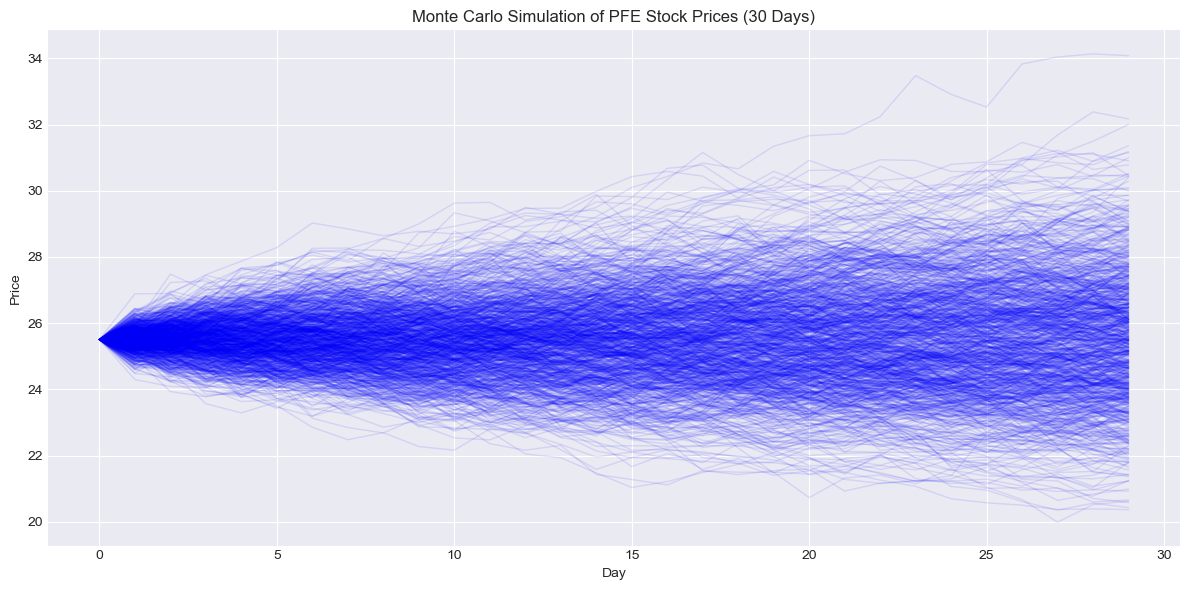

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(price_paths, linewidth=1, alpha=0.1, color='blue')
plt.title(f"Monte Carlo Simulation of {ticker} Stock Prices ({forecast_days} Days)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()


##📉 Step 6: Risk Metrics (e.g., VaR)

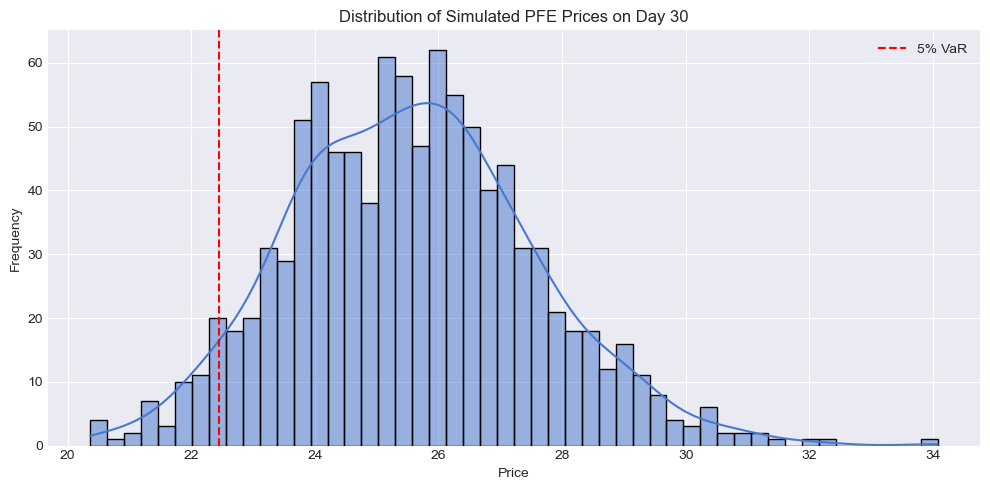

📉 5% Value at Risk (VaR): 3.05
📌 Expected Price Range: 20.36 - 34.08


In [16]:
# Distribution of simulated prices on final day
ending_prices = price_paths[-1, :]

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(ending_prices, bins=50, kde=True)
plt.axvline(np.percentile(ending_prices, 5), color='red', linestyle='--', label="5% VaR")
plt.title(f"Distribution of Simulated {ticker} Prices on Day {forecast_days}")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Value at Risk (5%)
VaR_95 = np.percentile(ending_prices, 5)
print(f"📉 5% Value at Risk (VaR): {last_price - VaR_95:.2f}")
print(f"📌 Expected Price Range: {ending_prices.min():.2f} - {ending_prices.max():.2f}")


In [17]:
# Save ending prices for report or further analysis
pd.DataFrame(ending_prices, columns=["Simulated_Price"]).to_csv("../results/monte_carlo_prices.csv", index=False)
